# Tensor Tucker Regression #

This notebook is the simulation study of tensor Tucker regression. Model description is available in the overleaf. Simulation data is generated by matlab, and is loaded in python. 

We have generated three different data sets which are independent and identically distributed. In the following procedure, we are going to use each one of these sets for model estimation, and calculate testing performances on the two other data sets. The model implementation has been coded in a sklearn model form, and can be imported directly. For convenience, we provide the original code in our TKR module, but will not call it. Instead, we will show how to load the module as a package and run it.

Below is the source code just for demonstration, but will not run.

In [9]:
"""
The first version of Tensor-on-tensor tucker regression code

Regression version, with continuous / binary response on every tensor elements
"""

#%%
import numpy as np 
import tensorly as tl 
from tensorly.tenalg import kronecker, multi_mode_dot
import matplotlib.pyplot as plt 
import time
from sklearn.metrics import zero_one_loss



#%%
def Tensor_MM_kron(Tx, modej, U_list):
    """
    Calculate X_{[j]}U^{(-modej)}T
    Tx: input tensor
    modej: index for mode j; here consider mode from 0, 1, ..., d - 1
    U_list: a list of projection matrix, length = d
    """
    U_temp = U_list[:]
    U_temp.pop(modej)     #Delete first, then reverse and do kroncker product. 
    U_temp = U_temp[::-1]
    res = kronecker(U_temp)
    les = tl.unfold(Tx, mode=modej)
    ans = np.dot(les, res.T)
    return ans




# %%
def Phi_mode(Y, mode_j):
    """
    Phi vector in the algorithm
    Given a list of reponse tensors y_i, return a column vector, each element is y_j unfold at mode j
    We should form it as matrix not tensor, so take np array
    """
    temp = [tl.unfold(i, mode_j) for i in Y]
    ans = np.hstack(tuple(temp))
    return ans.T

def F_MM(Tx_list, mode_j, U_list):
    """
    G vector in the algorithm
    Calculate the row vector
    """
    ans = [Tensor_MM_kron(i, mode_j, U_list) for i in Tx_list]
    return np.hstack(tuple(ans))



# %%
"""
Now use algorithm to calculate optimal solutions for each factor matrix U. The function runs iteratively
to search for the optimal solution
"""

def get_FactorU(Tx, Ty, U_list, mode_j, P_j, lambda_regula):
    """
    Estimate current factor matrix U with L2 penalty;
    It is for one-time estimation only
    Tx: Input Tensor
    Ty: Response Tensor
    mode_j: j-th mode
    P_j: j-th mode dimension for Tx!!!
    lambda_regula: regularization parameter for the L2 penalty
    """
    Phi = Phi_mode(Ty, mode_j)
    G = F_MM(Tx, mode_j, U_list)
    Iden = np.diag(np.ones(P_j))
    leftMM = np.dot(G, G.T) + 0.5 * lambda_regula * Iden
    LMM = np.linalg.pinv(leftMM)
    RMM = np.dot(G, Phi)
    U_new = np.dot(LMM, RMM)
    return U_new.T


def get_Binary_FactorU(Tx, Ty, U_list, mode_j, I_j, lambda_regula):
    """
    Estimate current factor matrix U with L2 penalty in Binary detection model;
    It is for one-time estimation only
    Tx: Input Tensor
    Ty: Response Tensor
    mode_j: j-th mode
    I_j: j-th mode dimension
    lambda_regula: regularization parameter for the L2 penalty

    Notice that in Binary case, both Tx and Ty are single tensor
    """
    Phi = Phi_mode(Ty, mode_j)
    temptensor = Tx[0]
    C_prod = tl.unfold(multi_mode_dot(temptensor, U_list), mode_j)
    res = np.multiply(Phi.T, C_prod)
    a = np.shape(res)
    for i in range(a[0]):
        for j in range(a[1]):
            if res[i, j] >= 1:
                Phi[j, i] = 0   # We want to change elements in Phi.T, so have to reverse index
#   Forcing phi_{ij} to be zero, we can actually remove the gradient coming from non_sv loss
    G = F_MM(Tx, mode_j, U_list)
    Iden = np.diag(np.ones(I_j))
    leftMM = np.dot(G, G.T) + 0.5 * lambda_regula * Iden
    LMM = np.linalg.pinv(leftMM)
    RMM = np.dot(G, Phi)
    U_new = np.dot(LMM, RMM)
    return U_new.T


def get_ObjVal(Tx, Ty, U_fac, lambda_regula, cla = False):
    """
    Calculate the objective function value
    """
    ans = 0.5 * lambda_regula * sum([np.linalg.norm(U)**2 for U in U_fac])
    if cla:
        res = 0
        for x, y in zip(Tx, Ty):
            temp_res = 1 - np.multiply(y, multi_mode_dot(x, U_fac)).flatten()
            res += sum([i **2 for i in temp_res if i > 0])
        res = res / len(Ty)
        return ans + res
    else:
        res = sum([np.linalg.norm(y, multi_mode_dot(x, U_fac)) ** 2 for (x, y) in zip(Tx, Ty)]) / len(Ty)
        return ans + res

def get_FacDiff(U_fac, U_hat):
    return sum([np.linalg.norm((Unew - Uold)) for (Unew, Uold) in zip (U_fac, U_hat)]) / len(U_fac)
    

# %%
"""
Start Solving the equation
"""
def T_Regression(Tx, Ty, lambda_regula, U_init = None, eta = 0.1, maxiter = 10, get_history = True):
    """
    Estimate factor matrices for the Tucker regression
    Tx: Input Tensor in shape I1 x ... Id; list with length n
    Ty: Output Tensor in shape P1 x ... Pd; list with length n
    lambda_regula: regularization parameter for the L2 penalty
    get_history: keep track of estimation error and provide information for model training
    """
    D = np.shape(Tx[0])
    P = np.shape(Ty[0])     # Tx and Ty are lists of tensors. In order to get tensor shape, look at Tx[0], Ty[0]
    d = len(P)
    if not U_init:
        print("Initial factor matrices U with random Gaussian matrix with elements iid confirms N(1, 1)")
        U_fac = [np.random.randn(i, j) + 1 for (i, j) in zip(P, D)]
    else:
        print("Using initial factor matrices for U")
        U_fac = U_init[:]
    est_err, iteration = 10000, 0
    U_hat = U_fac[:]
    err_history = []
    while iteration <= maxiter and est_err >= eta:
        obj_est = get_ObjVal(Tx, Ty, U_fac, lambda_regula)
        for j in range(d):
            U_temp = get_FactorU(Tx, Ty, U_fac, j, D[j], lambda_regula)
            U_fac[j] = U_temp
        est_err = get_FacDiff(U_hat, U_fac)
        U_hat = U_fac[:]
        iteration += 1
        err_history.append(obj_est)
    if get_history:
        return {"para": U_fac, "err_hist": err_history}
    return {"para" : U_fac}




def T_B_Regression(Tx, Ty, lambda_regula, U_init = None, eta = 0.1, maxiter = 100, get_history = True):
    """
    Estimate factor matrices for the Tucker Binary regression
    Tx: Input Tensor in shape I1 x ... Id; list with length n
    Ty: Output Tensor in shape P1 x ... Pd; list with length n
    lambda_regula: regularization parameter for the L2 penalty
    get_history: keep track of estimation error and provide information for model training
    """
    D = list(np.shape(Tx))
    P = list(np.shape(Ty))
    D.pop(0), P.pop(0)
    d = len(P)
    if not U_init:
        print("Initial factor matrices U with random Gaussian matrix with elements iid confirms N(1, 1)")
        U_fac = [np.random.randn(i, j) + 1 for (i, j) in zip(P, D)]
    else:
        print("Using initial factor matrices for U")
        U_fac = U_init[:]
    # U_fac[-1] = np.identity(P[-1])
    est_err, iteration = 10000, 0
    U_hat = U_fac[:]
    err_history = []
    while iteration <= maxiter and est_err >= eta:
        obj_est = get_ObjVal(Tx, Ty, U_fac, lambda_regula, cla=True)
        for j in range(d - 1):
            U_temp = get_Binary_FactorU(Tx, Ty, U_fac, j, D[j], lambda_regula)
            U_fac[j] = U_temp
        est_err = get_FacDiff(U_hat, U_fac)
        # print("Iternation {}......Done!".format(iteration))
        U_hat = U_fac[:]
        iteration += 1
        err_history.append(obj_est)
    if get_history:
        return {"para": U_fac, "err_hist": err_history}
    return {"para" : U_fac}







"""
Tensor product (tensordot) is a generalization of outer product for vector and Kroncker product for matrix
Outer product keep all the result in matrix form
Kroncker product also keep the result in matrix form
tensor product however, shape result in multi-dimensional array form, which we call tensor
But their elements are identical, and can be reshaped to be equal
In my case, tesnordot is right because I want to get multi-dimensional array
"""





class Tucker_Regression():

    """
    A Sklearn style model
    First specify model tunning parameter
    Then fit model
    Some private methods are provided
    """

    def __init__(self, eta = 0.1, maxiter = 10):
        self.eta = eta
        self.maxiter = maxiter
        return

    def fit(self, X, Y, lambda_regula, get_history = True):
        """
        Fitting model with a list of X and Y
        X: A list of predictor tensors
        Y: A list of response tensors
        X and Y should have the same length
        """
        temp = T_Regression(X, Y, lambda_regula, U_init=None, eta=self.eta, maxiter=self.maxiter, get_history=get_history)
        if get_history:
            self.U_fac, self.error_history = temp["para"], temp["err_hist"]
        else:
            self.U_fac = temp["para"]
        predict_train = [multi_mode_dot(tensor, self.U_fac) for tensor in X]
        self.MSE_Train = sum([np.linalg.norm((predY - trueY))**2 for (predY, trueY) in zip(predict_train, Y)]) / len(Y)
        return 

    def predict(self, newX, newY = None):
        """
        Make Prediction basing on fitted Tucker model
        NewX: list of new observed tensor X
        Tucker_Model: A Tucker_Regression object
        """
        pred = [multi_mode_dot(tensor, self.U_fac) for tensor in newX]
        if newY:
            loss = sum([np.linalg.norm((predY - Y))**2 for (predY, Y) in zip(pred, newY)]) / len(newY)
            return {"Prediction": pred, "MSE": loss}
        else:
            return {"Prediction" : pred}
    
    def Train_plot(self):
        if not self.error_history:
            print("Not tracking training procedure. Please re-train the model and set get_history = True!")
            return
        else:
            x = np.linspace(1, len(self.error_history), num = len(self.error_history))
            plt.figure(figsize=(8, 6))
            plt.plot(x, np.log(self.error_history))
            plt.xlabel("Iterations")
            plt.ylabel("(Averaged) Loss / Frobenius")
            plt.title("Training Procedure")
            plt.show()
            return
        


"""
Tucker Binary Regression model
"""
class Tucker_Binary_Regression():

    """
    A Sklearn style model
    First specify model tunning parameter
    Then fit model
    Some private methods are provided
    """

    def __init__(self, eta = 0.1, maxiter = 500):
        self.eta = eta
        self.maxiter = maxiter
        return

    def fit(self, X, Y, lambda_regula, get_history = True):
        """
        Fitting model with a list of X and Y
        X: A list of predictor tensors
        Y: A list of response tensors
        X and Y should have the same length
        """
        temp = T_B_Regression(X, Y, lambda_regula, U_init=None, eta=self.eta, maxiter=self.maxiter, get_history=get_history)
        if get_history:
            self.U_fac, self.error_history = temp["para"], temp["err_hist"]
        else:
            self.U_fac = temp["para"]
        predict_train = [np.sign(multi_mode_dot(tensor, self.U_fac)) for tensor in X]
        self.MSE_Train = sum([zero_one_loss(predY.flatten(), trueY.flatten(), normalize=True) for (predY, trueY) in zip(predict_train, Y)]) / len(Y)
        return 

    def predict(self, newX, newY = None):
        """
        Make Prediction basing on fitted Tucker model
        NewX: list of new observed tensor X
        Tucker_Model: A Tucker_Regression object
        """
        pred = [np.sign(multi_mode_dot(tensor, self.U_fac)) for tensor in newX]
        if newY:
            loss = sum([zero_one_loss(predY.flatten(), Y.flatten(), normalize=True) for (predY, Y) in zip(pred, newY)]) / len(newY)
            return {"Prediction": pred, "MSE": loss}
        else:
            return {"Prediction" : pred}
    
    def Train_plot(self):
        if not self.error_history:
            print("Not tracking training procedure. Please re-train the model and set get_history = True!")
            return
        else:
            x = np.linspace(1, len(self.error_history), num = len(self.error_history))
            plt.figure()
            plt.plot(x, np.log(self.error_history))
            plt.xlabel("Iterations")
            plt.ylabel("Objective Function Values")
            plt.title("Training Procedure")
            plt.show()
            return









    

    





### Simulation Result ###

We will load package and run the simulation directly. Some tuning parameters are specified here. 
    1. Regularization parameter lambda is 1
    2. Maximum number of iteration is 100, convergence parameter eta is 0.1

Initial factor matrices U with random Gaussian matrix with elements iid confirms N(1, 1)
Iternation 0......Done!
Iternation 1......Done!
Iternation 2......Done!
Iternation 3......Done!
Iternation 4......Done!
Iternation 5......Done!
Iternation 6......Done!
Iternation 7......Done!
Iternation 8......Done!
Iternation 9......Done!
Iternation 10......Done!
Iternation 11......Done!
Iternation 12......Done!
Iternation 13......Done!
Iternation 14......Done!
Iternation 15......Done!
Iternation 16......Done!
Iternation 17......Done!
Iternation 18......Done!
Iternation 19......Done!
Iternation 20......Done!
Iternation 21......Done!
Iternation 22......Done!
Iternation 23......Done!
Iternation 24......Done!
Iternation 25......Done!
Iternation 26......Done!
Iternation 27......Done!
Iternation 28......Done!
Iternation 29......Done!
Iternation 30......Done!
Iternation 31......Done!
Iternation 32......Done!
Iternation 33......Done!
Iternation 34......Done!
Iternation 35......Done!
Iternation 36......Do

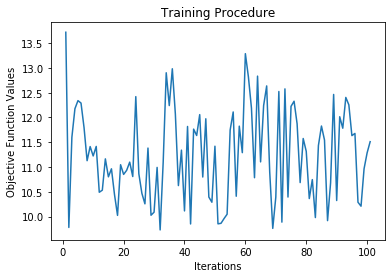

The average error rate of binary classification is 0.03923777777777776.


In [2]:
"""
Test File
Tucker regression
"""

import numpy as np 
import tensorly as tl 
import Tucker_ver1 as TKR 
import scipy.io as sio
import os


# Data generation, import directly from matlab
dataX_file = 'D:\\OneDrive - Michigan State University\\Documents\\Tensor Regression\\Tensor_Tucker\\Code\\X_Simu'
dataY_file = 'D:\\OneDrive - Michigan State University\\Documents\\Tensor Regression\\Tensor_Tucker\\Code\\Y_Simu'
listX = os.listdir(dataX_file)
listY = os.listdir(dataY_file)
Ty = [np.array(sio.loadmat(os.path.join(dataX_file, listX[1]))['X'])]
Tx = [np.array(sio.loadmat(os.path.join(dataY_file, listY[1]))['Y'])]


np.random.seed(1)

mymodel = TKR.Tucker_Binary_Regression(eta = 0.1, maxiter = 100)
mymodel.fit(X=Tx, Y=Ty, lambda_regula=0.5)

print("Model Training error is {}.".format(mymodel.MSE_Train))

mymodel.Train_plot()

# Testing data
newY = [np.array(sio.loadmat(os.path.join(dataX_file, listX[0]))['X']), \
    np.array(sio.loadmat(os.path.join(dataX_file, listX[2]))['X'])]
newX = [np.array(sio.loadmat(os.path.join(dataY_file, listY[0]))['Y']), \
    np.array(sio.loadmat(os.path.join(dataY_file, listY[2]))['Y'])]

err = mymodel.predict(newX, newY)    

print("The average error rate of binary classification is {}.".format(err['MSE']))

**Second Case**

Initial factor matrices U with random Gaussian matrix with elements iid confirms N(1, 1)
Iternation 0......Done!
Iternation 1......Done!
Iternation 2......Done!
Iternation 3......Done!
Iternation 4......Done!
Iternation 5......Done!
Iternation 6......Done!
Iternation 7......Done!
Iternation 8......Done!
Iternation 9......Done!
Iternation 10......Done!
Iternation 11......Done!
Iternation 12......Done!
Iternation 13......Done!
Iternation 14......Done!
Iternation 15......Done!
Iternation 16......Done!
Iternation 17......Done!
Iternation 18......Done!
Iternation 19......Done!
Iternation 20......Done!
Iternation 21......Done!
Iternation 22......Done!
Iternation 23......Done!
Iternation 24......Done!
Iternation 25......Done!
Iternation 26......Done!
Iternation 27......Done!
Iternation 28......Done!
Iternation 29......Done!
Iternation 30......Done!
Iternation 31......Done!
Iternation 32......Done!
Iternation 33......Done!
Iternation 34......Done!
Iternation 35......Done!
Iternation 36......Do

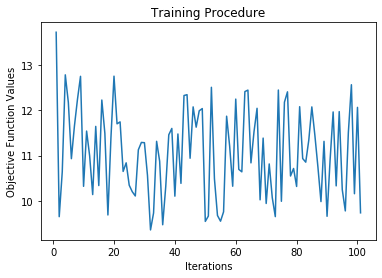

The average error rate of binary classification is 0.1127111111111111.


In [1]:
"""
Test File
Tucker regression
"""

import numpy as np 
import tensorly as tl 
import Tucker_ver1 as TKR 
import scipy.io as sio
import os


# Data generation, import directly from matlab
dataX_file = 'D:\\OneDrive - Michigan State University\\Documents\\Tensor Regression\\Tensor_Tucker\\Code\\X_Simu'
dataY_file = 'D:\\OneDrive - Michigan State University\\Documents\\Tensor Regression\\Tensor_Tucker\\Code\\Y_Simu'
listX = os.listdir(dataX_file)
listY = os.listdir(dataY_file)
Ty = [np.array(sio.loadmat(os.path.join(dataX_file, listX[0]))['X'])]
Tx = [np.array(sio.loadmat(os.path.join(dataY_file, listY[0]))['Y'])]


np.random.seed(1)

mymodel = TKR.Tucker_Binary_Regression(eta = 0.1, maxiter = 100)
mymodel.fit(X=Tx, Y=Ty, lambda_regula=0.5)

print("Model Training error is {}.".format(mymodel.MSE_Train))

mymodel.Train_plot()

# Testing data
newY = [np.array(sio.loadmat(os.path.join(dataX_file, listX[1]))['X']), \
    np.array(sio.loadmat(os.path.join(dataX_file, listX[2]))['X'])]
newX = [np.array(sio.loadmat(os.path.join(dataY_file, listY[1]))['Y']), \
    np.array(sio.loadmat(os.path.join(dataY_file, listY[2]))['Y'])]

err = mymodel.predict(newX, newY)    

print("The average error rate of binary classification is {}.".format(err['MSE']))

**Third Case**

Initial factor matrices U with random Gaussian matrix with elements iid confirms N(1, 1)
Iternation 0......Done!
Iternation 1......Done!
Iternation 2......Done!
Iternation 3......Done!
Iternation 4......Done!
Iternation 5......Done!
Iternation 6......Done!
Iternation 7......Done!
Iternation 8......Done!
Iternation 9......Done!
Iternation 10......Done!
Iternation 11......Done!
Iternation 12......Done!
Iternation 13......Done!
Iternation 14......Done!
Iternation 15......Done!
Iternation 16......Done!
Iternation 17......Done!
Iternation 18......Done!
Iternation 19......Done!
Iternation 20......Done!
Iternation 21......Done!
Iternation 22......Done!
Iternation 23......Done!
Iternation 24......Done!
Iternation 25......Done!
Iternation 26......Done!
Iternation 27......Done!
Iternation 28......Done!
Iternation 29......Done!
Iternation 30......Done!
Iternation 31......Done!
Iternation 32......Done!
Iternation 33......Done!
Iternation 34......Done!
Iternation 35......Done!
Iternation 36......Do

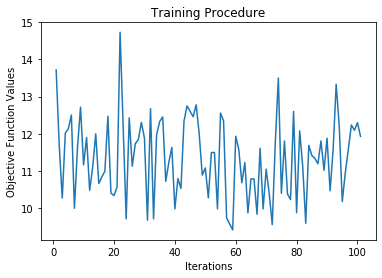

The average error rate of binary classification is 0.23231333333333337.


In [1]:
"""
Test File
Tucker regression
"""

import numpy as np 
import tensorly as tl 
import Tucker_ver1 as TKR 
import scipy.io as sio
import os


# Data generation, import directly from matlab
dataX_file = 'D:\\OneDrive - Michigan State University\\Documents\\Tensor Regression\\Tensor_Tucker\\Code\\X_Simu'
dataY_file = 'D:\\OneDrive - Michigan State University\\Documents\\Tensor Regression\\Tensor_Tucker\\Code\\Y_Simu'
listX = os.listdir(dataX_file)
listY = os.listdir(dataY_file)
Ty = [np.array(sio.loadmat(os.path.join(dataX_file, listX[2]))['X'])]
Tx = [np.array(sio.loadmat(os.path.join(dataY_file, listY[2]))['Y'])]


np.random.seed(1)

mymodel = TKR.Tucker_Binary_Regression(eta = 0.1, maxiter = 100)
mymodel.fit(X=Tx, Y=Ty, lambda_regula=0.5)

print("Model Training error is {}.".format(mymodel.MSE_Train))

mymodel.Train_plot()

# Testing data
newY = [np.array(sio.loadmat(os.path.join(dataX_file, listX[0]))['X']), \
    np.array(sio.loadmat(os.path.join(dataX_file, listX[1]))['X'])]
newX = [np.array(sio.loadmat(os.path.join(dataY_file, listY[0]))['Y']), \
    np.array(sio.loadmat(os.path.join(dataY_file, listY[1]))['Y'])]

err = mymodel.predict(newX, newY)    

print("The average error rate of binary classification is {}.".format(err['MSE']))

In [ ]:
newX[0].shape
pred = err['Prediction']
pred[0].shape
import matplotlib.pyplot as plt 

ori = newX[0].flatten()
tr = newY[0].flatten()
tmp = pred[0].flatten()

step = 0
while step + 40 < ori.shape[0]:
    plt.figure(figsize=(30, 6))
    plt.plot(ori[step : step + 40], linewidth = 1, label = 'Traffic')
    plt.plot(tr[step : step + 40], linewidth = 1, label = 'True')
    plt.plot(tmp[step : step + 40], linewidth = 1, label = 'Detect')
    plt.legend()
    plt.show()
    step += 40